
## Hands-on experience with tuning neural networks

Consider a set of points similar to ones shown in the figure below. The figure shows *labeled data* - some points are in category A, indicated by
red circles, and the rest are in category B, indicated by blue triangles. For example, the data
may show oil drilling sites on a map, where category A denotes a successful outcome.
Can we use this data to categorize a newly proposed drilling site? Our job is to
construct a mapping that takes any point and returns either a circle or a triangle.

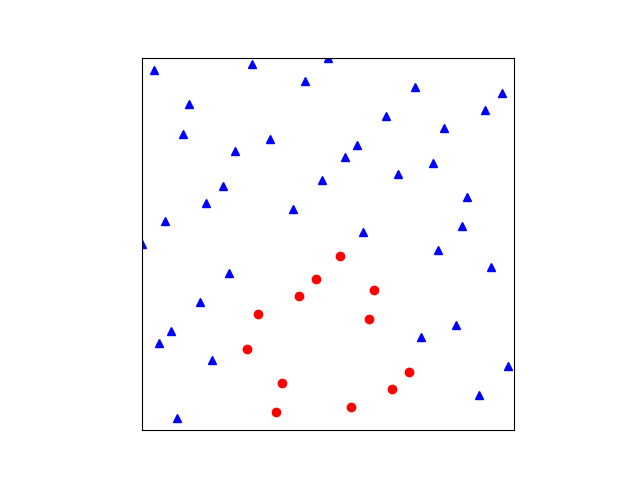


There are many reasonable ways to construct such a mapping. Here we consider the
neural network approach.

We construct the neural network using layers of neurons. In each layer, every neuron
outputs a single real number, which is passed to every neuron in the next layer. At
the next layer, each neuron forms its own weighted combination of these values, adds
its own bias, and applies the sigmoid function. 

If the real numbers produced by the neurons in one layer are collected into a vector, $\mathbf{a}$, then
the vector of outputs from the next layer has the form

$$\sigma\left(W \mathbf{a} + \mathbf{b}\right) .$$

Here, $\sigma()$ is sigmoid function, $W$ is a matrix and $\mathbf{b}$ is a vector. We say that $W$ contains the *weights* and $\mathbf{b}$
contains the *biases*. The number of columns in $W$ matches the number of neurons
that produced the vector $\mathbf{a}$ at the previous layer. The number of rows in $W$ matches
the number of neurons at the current layer. The number of components in $\mathbf{b}$ also
matches the number of neurons at the current layer.


The figure below represents a possible neural network with four layers. You apply a similar
network to the problem of categorazing points in the plane. 

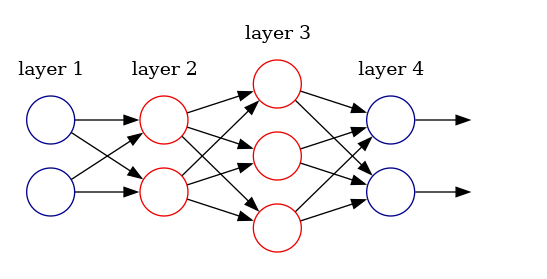


Load required packages:

In [ ]:

using PyPlot
using LinearAlgebra: norm

using Random: seed!
using Sobol

using ProgressMeter


Load the code for machine learning:

In [ ]:

include("ml-higham.jl");


Intialize random number generators:

In [ ]:

seed!(123)

s = SobolSeq(2)
skip(s, rand(1:200000)); # skip a random number of random points


### Prepare data:

In [ ]:

spdim = 2               # spatial dimension of data points
np = 50                 # number of data points

x = zeros(spdim, np);   # coordinates of the points
y = zeros(spdim, np);   # labels of data points


The function that we use for generation the labels:

In [ ]:

fun(x) = (2*(x[1] - 0.5))^2 + 2*(x[2] - 0.5)^2 - (1/2)^2   # points in the center


Generate pair of points and assign the labels

In [ ]:

for i = 1:np
    x[:, i] .= Sobol.next!(s)
        if fun(x[:, i]) < 0.0
        y[1, i] = 1.0
        y[2, i] = 0.0
    else
        y[1, i] = 0.0
        y[2, i] = 1.0
    end
end


Plot the data:

In [ ]:

function show_data(x, y)
    for i = 1:np
        col = "blue"
        mar = "^"
        if y[1, i] > y[2, i]
            col = "red"
            mar = "o"
        end
        plot(x[1, i], x[2, i], linestyle="none", marker=mar, c=col, markersize=6)
    end
    axis("square")
    xlim(0.0, 1.0)
    ylim(0.0, 1.0)
    ax = gca()
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
end

In [ ]:
show_data(x, y);

### The model


The number of neurons in each layer:

In [ ]:

Ns = [2, 2, 3, 2]   # <- those are the parameters to tune!


Initialize the weights, biases, and working arrays for the model:

In [ ]:

p, delta = model_init(Ns);


Let's check the predictions of untrained model:

In [ ]:

@show predict2([0.5, 0.5], p)
@show predict2([0.9, 0.9], p);

### Training

In [ ]:

eta = 0.2                    # learning rate, can be tuned
niters = Int(2e6)            # the number of iterations
savecosts = zeros(niters);   # arrays to store the values of the cost function

In [ ]:

fbpropagate2!(savecosts, p, delta, eta, niters, x, y)


Let's see the learning progress - predictions of trained model:

In [ ]:

@show predict2([0.5, 0.5], p)
@show predict2([0.9, 0.9], p);

In [ ]:

"""
    areamap2!(mvals, xvals, yvals, pfin)

Calculate the prediction of the model on a grid of points
"""
function areamap2!(mvals, xvals, yvals, pfin)

    n = length(xvals)
    xy = zeros(2)
    for k1 = 1:n
        xy[1] = xvals[k1]
        for k2 = 1:n
            xy[2] = yvals[k2]            
            mvals[k2, k1] = findmax(predict2(xy, pfin))[2] - 1.0
        end
    end
    return nothing
end


Plot the original data and the contour plot of the predictions:

In [ ]:

N = 500
xvals = range(0.0, 1.0, N)
yvals = range(0.0, 1.0, N)
mvals = zeros(N, N);
areamap2!(mvals, xvals, yvals, p);

In [ ]:

show_data(x, y)
cs = contour(xvals, yvals, mvals, levels=[0.5]);


Visualize cost minimization:

In [ ]:

semilogy(1:niters, savecosts)
grid(true)
xlabel("number of iterations")
ylabel("cost function");